# WandB Results Plotting

This notebook plots results from the feature-steering-RL wandb project, specifically:
- **Gemma2-2B-sparsity-sweep**: Plots vs l1_act_coeff
- **Gemma2-2B-layer-sweep**: Plots vs layer (from sae_id)

We'll create 4 plots:
1. eval/loss vs l1_act_coeff (sparsity sweep)
2. train/steering_vector/l0_norm_sparsity vs l1_act_coeff (sparsity sweep)
3. eval/loss vs layer (layer sweep + layer 12 from sparsity)
4. train/steering_vector/l0_norm_sparsity vs layer (layer sweep + layer 12 from sparsity)

In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import os
import re

# Load environment variables
load_dotenv()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [2]:
# Initialize wandb API
api = wandb.Api()

# Project and entity settings - corrected based on user feedback
entity = "feature-steering-rl"  # Entity name
# We'll fetch from individual projects that correspond to the tags

print(f"Connecting to wandb entity: {entity}")
print("Will fetch from projects: Gemma2-2B-sparsity-sweep and Gemma2-2B-layer-sweep")

Connecting to wandb entity: feature-steering-rl
Will fetch from projects: Gemma2-2B-sparsity-sweep and Gemma2-2B-layer-sweep


## Data Collection Functions

In [3]:
def extract_layer_from_sae_id(sae_id):
    """
    Extract layer number from sae_id.
    Example: "layer_12/width_65k/average_l0_21" -> 12
    """
    if pd.isna(sae_id):
        return None
    
    match = re.search(r'layer_(\d+)', str(sae_id))  # Fixed: removed extra backslash
    if match:
        return int(match.group(1))
    return None

def get_runs_data(projects_list):
    """
    Get run data from wandb for specific projects.
    
    Args:
        projects_list: List of project names to fetch from
    
    Returns:
        DataFrame with run data
    """
    all_runs_data = []
    
    for project_name in projects_list:
        print(f"Fetching runs from project: {project_name}")
        
        runs = api.runs(f"{entity}/{project_name}")
        
        print(f"Found {len(runs)} runs")
        
        for run in runs:
            # Get final metrics from summary
            summary_metrics = run.summary
            
            # Get config values
            config = run.config
            
            run_data = {
                'run_id': run.id,
                'run_name': run.name,
                'project_name': project_name,  # Use actual project name instead of tag
                'state': run.state,
                
                # Final metrics
                'eval_loss': summary_metrics.get('eval/loss'),
                'train_l0_norm_sparsity': summary_metrics.get('train/steering_vector/l0_norm_sparsity'),
                
                # Config values
                'l1_act_coeff': config.get('training', {}).get('l1_act_coeff'),
                'sae_id': config.get('architecture', {}).get('sae', {}).get('sae_id'),
                
                # Extract layer from sae_id
                'layer': None,  # Will be computed below
            }
            
            # Extract layer number
            run_data['layer'] = extract_layer_from_sae_id(run_data['sae_id'])
            
            all_runs_data.append(run_data)
    
    df = pd.DataFrame(all_runs_data)
    
    # Filter out failed runs and runs without required data
    df = df[df['state'] == 'finished']
    
    print(f"\nTotal finished runs: {len(df)}")
    print(f"Runs with eval_loss: {df['eval_loss'].notna().sum()}")
    print(f"Runs with l0_norm_sparsity: {df['train_l0_norm_sparsity'].notna().sum()}")
    
    return df

## Fetch Data from WandB

In [4]:
# Define the projects to fetch from
projects_to_fetch = [
    "Gemma2-2B-sparsity-sweep",
    "Gemma2-2B-layer-sweep"
]

# Fetch all run data
df = get_runs_data(projects_to_fetch)

print("\\nDataframe shape:", df.shape)
print("\\nProject breakdown:")
print(df['project_name'].value_counts())

Fetching runs from project: Gemma2-2B-sparsity-sweep
Found 4 runs
Fetching runs from project: Gemma2-2B-layer-sweep
Found 4 runs
Fetching runs from project: Gemma2-2B-layer-sweep
Found 4 runs

Total finished runs: 8
Runs with eval_loss: 8
Runs with l0_norm_sparsity: 8
\nDataframe shape: (8, 9)
\nProject breakdown:
project_name
Gemma2-2B-sparsity-sweep    4
Gemma2-2B-layer-sweep       4
Name: count, dtype: int64
Found 4 runs

Total finished runs: 8
Runs with eval_loss: 8
Runs with l0_norm_sparsity: 8
\nDataframe shape: (8, 9)
\nProject breakdown:
project_name
Gemma2-2B-sparsity-sweep    4
Gemma2-2B-layer-sweep       4
Name: count, dtype: int64


In [5]:
# Display sample of the data
print("Sample of collected data:")
display(df.head())

print("\nData summary:")
print(df.describe())

Sample of collected data:


,run_id,run_name,project_name,state,eval_loss,train_l0_norm_sparsity,l1_act_coeff,sae_id,layer
0,v9krpkmb,usual-sun-1,Gemma2-2B-sparsity-sweep,finished,3.333673,2056.731445,0.020,layer_12/width_65k/average_l0_21,12
1,rk7petzy,dazzling-deluge-2,Gemma2-2B-sparsity-sweep,finished,4.220674,1225.074341,0.040,layer_12/width_65k/average_l0_21,12
2,9ab1d51h,golden-snowflake-3,Gemma2-2B-sparsity-sweep,finished,2.845299,4368.502441,0.008,layer_12/width_65k/average_l0_21,12
3,8jhbxqwj,fanciful-flower-4,Gemma2-2B-sparsity-sweep,finished,2.735332,5411.239258,0.006,layer_12/width_65k/average_l0_21,12
4,nnbk5bvv,bright-pine-5,Gemma2-2B-layer-sweep,finished,2.935771,3645.958252,0.010,layer_12/width_65k/average_l0_21,12



Data summary:
       eval_loss  train_l0_norm_sparsity  l1_act_coeff      layer
count   8.000000                8.000000      8.000000   8.000000
mean    3.823214             2480.464617      0.014250  13.500000
std     0.985989             1894.875595      0.011184   5.318432
min     2.735332              164.697342      0.006000   6.000000
25%     2.913153             1009.389542      0.009500  12.000000
50%     3.777173             2332.955078      0.010000  12.000000
75%     4.511917             3826.594299      0.012500  13.500000
max     5.129177             5411.239258      0.040000  24.000000


## Data Preparation

In [6]:
# Separate data by project type
sparsity_data = df[df['project_name'] == 'Gemma2-2B-sparsity-sweep'].copy()
layer_data = df[df['project_name'] == 'Gemma2-2B-layer-sweep'].copy()

print(f"Sparsity sweep runs: {len(sparsity_data)}")
print(f"Layer sweep runs: {len(layer_data)}")

# For sparsity analysis, add layer 12 data from layer sweep (different l1 norm values)
layer_12_from_layer_sweep = layer_data[layer_data['layer'] == 12].copy()
if len(layer_12_from_layer_sweep) > 0:
    print(f"Adding {len(layer_12_from_layer_sweep)} layer 12 runs from layer sweep to sparsity analysis")
    # Add a note to distinguish the source
    layer_12_from_layer_sweep['source'] = 'layer-sweep'
    sparsity_data['source'] = 'sparsity-sweep'
    
    # Combine for sparsity analysis
    combined_sparsity_data = pd.concat([sparsity_data, layer_12_from_layer_sweep], ignore_index=True)
else:
    combined_sparsity_data = sparsity_data.copy()
    combined_sparsity_data['source'] = 'sparsity-sweep'

# Keep layer data separate for layer analysis (no additional data needed)
layer_data['source'] = 'layer-sweep'

print(f"Combined sparsity data: {len(combined_sparsity_data)} runs")
print(f"Layer data: {len(layer_data)} runs")

Sparsity sweep runs: 4
Layer sweep runs: 4
Adding 1 layer 12 runs from layer sweep to sparsity analysis
Combined sparsity data: 5 runs
Layer data: 4 runs


In [7]:
# Check data availability for plotting
print("Combined sparsity data availability:")
print(f"  - Runs with l1_act_coeff: {combined_sparsity_data['l1_act_coeff'].notna().sum()}")
print(f"  - Runs with eval_loss: {combined_sparsity_data['eval_loss'].notna().sum()}")
print(f"  - Runs with l0_norm_sparsity: {combined_sparsity_data['train_l0_norm_sparsity'].notna().sum()}")

print("\nLayer sweep data availability:")
print(f"  - Runs with layer info: {layer_data['layer'].notna().sum()}")
print(f"  - Runs with eval_loss: {layer_data['eval_loss'].notna().sum()}")
print(f"  - Runs with l0_norm_sparsity: {layer_data['train_l0_norm_sparsity'].notna().sum()}")

print("\nUnique l1_act_coeff values in combined sparsity data:")
print(sorted(combined_sparsity_data['l1_act_coeff'].dropna().unique()))

print("\nUnique layers in layer data:")
print(sorted(layer_data['layer'].dropna().unique()))

Combined sparsity data availability:
  - Runs with l1_act_coeff: 5
  - Runs with eval_loss: 5
  - Runs with l0_norm_sparsity: 5

Layer sweep data availability:
  - Runs with layer info: 4
  - Runs with eval_loss: 4
  - Runs with l0_norm_sparsity: 4

Unique l1_act_coeff values in combined sparsity data:
[0.006, 0.008, 0.01, 0.02, 0.04]

Unique layers in layer data:
[6, 12, 18, 24]


## Plotting Functions

In [8]:
def create_plot(data, x_col, y_col, title, xlabel, ylabel, color_col=None, plot_type='bar', force_single_color=False):
    """
    Create a bar plot or scatter plot with optional coloring.
    """
    # Filter out rows with missing data
    plot_data = data.dropna(subset=[x_col, y_col])
    
    if len(plot_data) == 0:
        print(f"No data available for {title}")
        return None
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if plot_type == 'bar':
        if force_single_color or not (color_col and color_col in plot_data.columns):
            # Simple bar plot with single color - aggregate all data points by x value
            grouped_data = plot_data.groupby(x_col)[y_col].mean().sort_index()
            
            # Create discrete x-axis with equal spacing
            x_positions = range(len(grouped_data))
            ax.bar(x_positions, grouped_data.values, alpha=0.7, width=0.8, color='steelblue')
            
            # Set x-axis labels to show the actual values
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f'{x:.3f}' if isinstance(x, float) else str(x) for x in grouped_data.index])
        else:
            # Create grouped bar plot with colors
            grouped_color_data = plot_data.groupby([x_col, color_col])[y_col].mean().unstack(fill_value=0)
            grouped_color_data.plot(kind='bar', ax=ax, alpha=0.7, width=0.8, legend=False)
    else:
        # Scatter plot (fallback)
        if color_col and color_col in plot_data.columns and not force_single_color:
            for group_val in plot_data[color_col].unique():
                group_data = plot_data[plot_data[color_col] == group_val]
                ax.scatter(group_data[x_col], group_data[y_col], 
                          alpha=0.7, s=60)
        else:
            ax.scatter(plot_data[x_col], plot_data[y_col], alpha=0.7, s=60)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## Plot 1: Sparsity Sweep - eval/loss vs l1_act_coeff

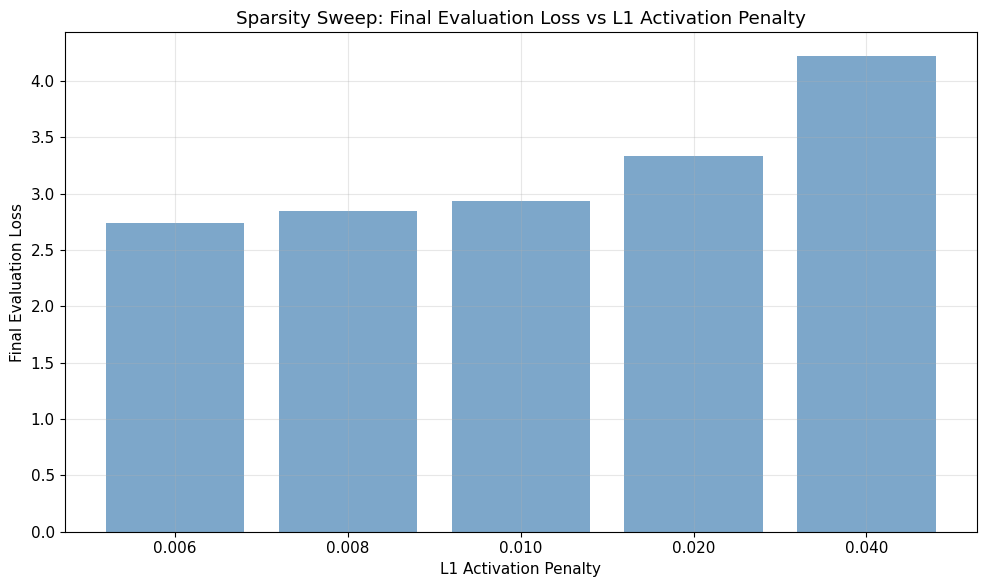


Datapoints: 5
L1 coeff range: 0.0060 to 0.0400
Eval loss range: 2.7353 to 4.2207
Source breakdown:
source
sparsity-sweep    4
layer-sweep       1
Name: count, dtype: int64


In [9]:
fig1 = create_plot(
    data=combined_sparsity_data,
    x_col='l1_act_coeff',
    y_col='eval_loss',
    title='Sparsity Sweep: Final Evaluation Loss vs L1 Activation Penalty',
    xlabel='L1 Activation Penalty',
    ylabel='Final Evaluation Loss',
    plot_type='bar',
    force_single_color=True
)

if fig1:
    plt.show()
    
    # Print some statistics
    valid_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'eval_loss'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"L1 coeff range: {valid_data['l1_act_coeff'].min():.4f} to {valid_data['l1_act_coeff'].max():.4f}")
        print(f"Eval loss range: {valid_data['eval_loss'].min():.4f} to {valid_data['eval_loss'].max():.4f}")
        print(f"Source breakdown:")
        print(valid_data['source'].value_counts())

## Plot 2: Sparsity Sweep - train/steering_vector/l0_norm_sparsity vs l1_act_coeff

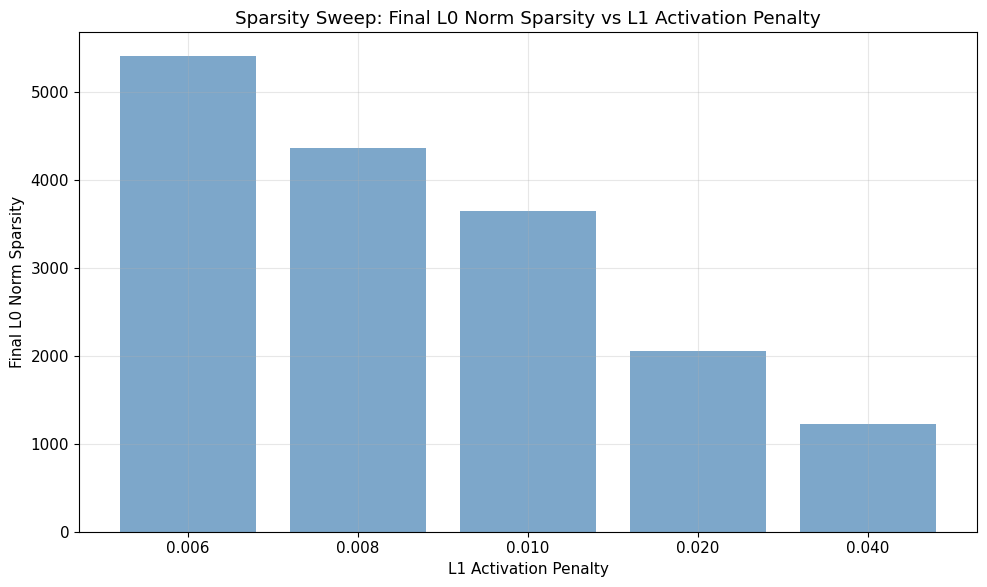


Datapoints: 5
L1 coeff range: 0.0060 to 0.0400
L0 sparsity range: 1225.0743 to 5411.2393
Source breakdown:
source
sparsity-sweep    4
layer-sweep       1
Name: count, dtype: int64


In [10]:
fig2 = create_plot(
    data=combined_sparsity_data,
    x_col='l1_act_coeff',
    y_col='train_l0_norm_sparsity',
    title='Sparsity Sweep: Final L0 Norm Sparsity vs L1 Activation Penalty',
    xlabel='L1 Activation Penalty',
    ylabel='Final L0 Norm Sparsity',
    plot_type='bar',
    force_single_color=True
)

if fig2:
    plt.show()
    
    # Print some statistics
    valid_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'train_l0_norm_sparsity'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"L1 coeff range: {valid_data['l1_act_coeff'].min():.4f} to {valid_data['l1_act_coeff'].max():.4f}")
        print(f"L0 sparsity range: {valid_data['train_l0_norm_sparsity'].min():.4f} to {valid_data['train_l0_norm_sparsity'].max():.4f}")
        print(f"Source breakdown:")
        print(valid_data['source'].value_counts())

## Plot 3: Layer Sweep - eval/loss vs layer

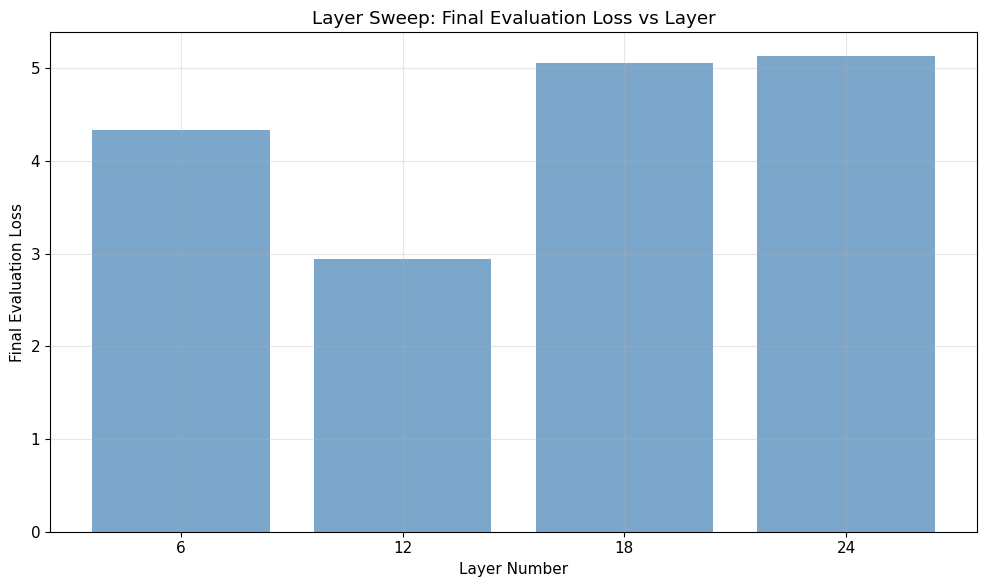


Datapoints: 4
Layer range: 6 to 24
Eval loss range: 2.9358 to 5.1292


In [11]:
fig3 = create_plot(
    data=layer_data,
    x_col='layer',
    y_col='eval_loss',
    title='Layer Sweep: Final Evaluation Loss vs Layer',
    xlabel='Layer Number',
    ylabel='Final Evaluation Loss',
    plot_type='bar'
)

if fig3:
    plt.show()
    
    # Print some statistics
    valid_data = layer_data.dropna(subset=['layer', 'eval_loss'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"Layer range: {int(valid_data['layer'].min())} to {int(valid_data['layer'].max())}")
        print(f"Eval loss range: {valid_data['eval_loss'].min():.4f} to {valid_data['eval_loss'].max():.4f}")

## Plot 4: Layer Sweep - train/steering_vector/l0_norm_sparsity vs layer

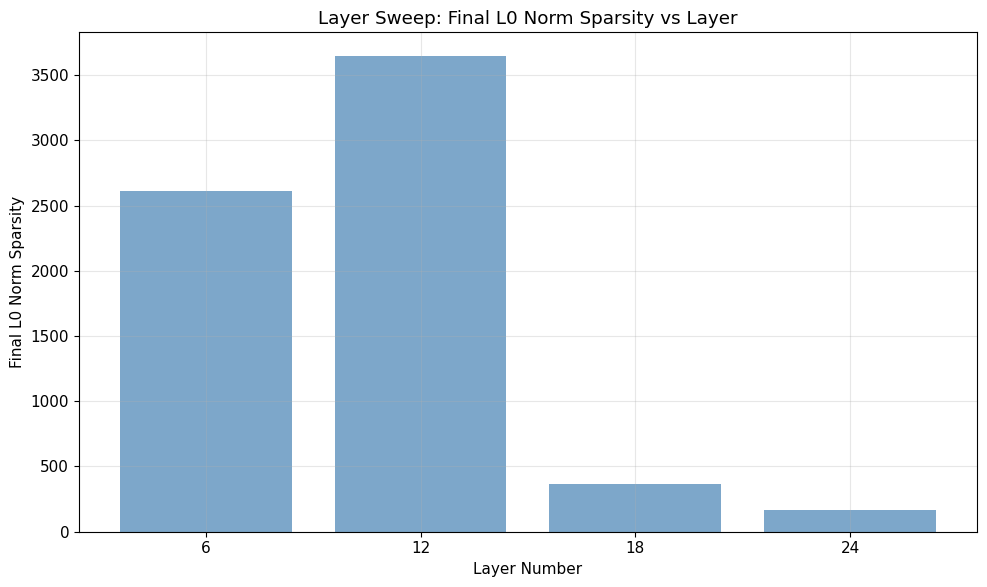


Datapoints: 4
Layer range: 6 to 24
L0 sparsity range: 164.6973 to 3645.9583


In [12]:
fig4 = create_plot(
    data=layer_data,
    x_col='layer',
    y_col='train_l0_norm_sparsity',
    title='Layer Sweep: Final L0 Norm Sparsity vs Layer',
    xlabel='Layer Number',
    ylabel='Final L0 Norm Sparsity',
    plot_type='bar'
)

if fig4:
    plt.show()
    
    # Print some statistics
    valid_data = layer_data.dropna(subset=['layer', 'train_l0_norm_sparsity'])
    if len(valid_data) > 0:
        print(f"\nDatapoints: {len(valid_data)}")
        print(f"Layer range: {int(valid_data['layer'].min())} to {int(valid_data['layer'].max())}")
        print(f"L0 sparsity range: {valid_data['train_l0_norm_sparsity'].min():.4f} to {valid_data['train_l0_norm_sparsity'].max():.4f}")

## Summary Statistics and Data Export

In [13]:
# Summary of all collected data
print("=== DATA SUMMARY ===")
print(f"Total runs collected: {len(df)}")
print(f"Original sparsity sweep runs: {len(sparsity_data)}")
print(f"Original layer sweep runs: {len(layer_data)}")
print(f"Combined sparsity analysis runs: {len(combined_sparsity_data)}")

print("\n=== MISSING DATA ANALYSIS ===")
missing_eval_loss = df['eval_loss'].isna().sum()
missing_l0_sparsity = df['train_l0_norm_sparsity'].isna().sum()
missing_l1_coeff = df['l1_act_coeff'].isna().sum()
missing_layer = df['layer'].isna().sum()

print(f"Runs missing eval_loss: {missing_eval_loss}/{len(df)}")
print(f"Runs missing l0_norm_sparsity: {missing_l0_sparsity}/{len(df)}")
print(f"Runs missing l1_act_coeff: {missing_l1_coeff}/{len(df)}")
print(f"Runs missing layer info: {missing_layer}/{len(df)}")

=== DATA SUMMARY ===
Total runs collected: 8
Original sparsity sweep runs: 4
Original layer sweep runs: 4
Combined sparsity analysis runs: 5

=== MISSING DATA ANALYSIS ===
Runs missing eval_loss: 0/8
Runs missing l0_norm_sparsity: 0/8
Runs missing l1_act_coeff: 0/8
Runs missing layer info: 0/8


In [14]:
# Save data to CSV for further analysis
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save full dataset
df.to_csv(f"{output_dir}/wandb_results_full.csv", index=False)
print(f"Full dataset saved to {output_dir}/wandb_results_full.csv")

# Save combined sparsity data
combined_sparsity_data.to_csv(f"{output_dir}/combined_sparsity_results.csv", index=False)
print(f"Combined sparsity data saved to {output_dir}/combined_sparsity_results.csv")

# Save layer data
layer_data.to_csv(f"{output_dir}/layer_sweep_results.csv", index=False)
print(f"Layer sweep data saved to {output_dir}/layer_sweep_results.csv")

Full dataset saved to outputs/wandb_results_full.csv
Combined sparsity data saved to outputs/combined_sparsity_results.csv
Layer sweep data saved to outputs/layer_sweep_results.csv


## Additional Analysis (Optional)

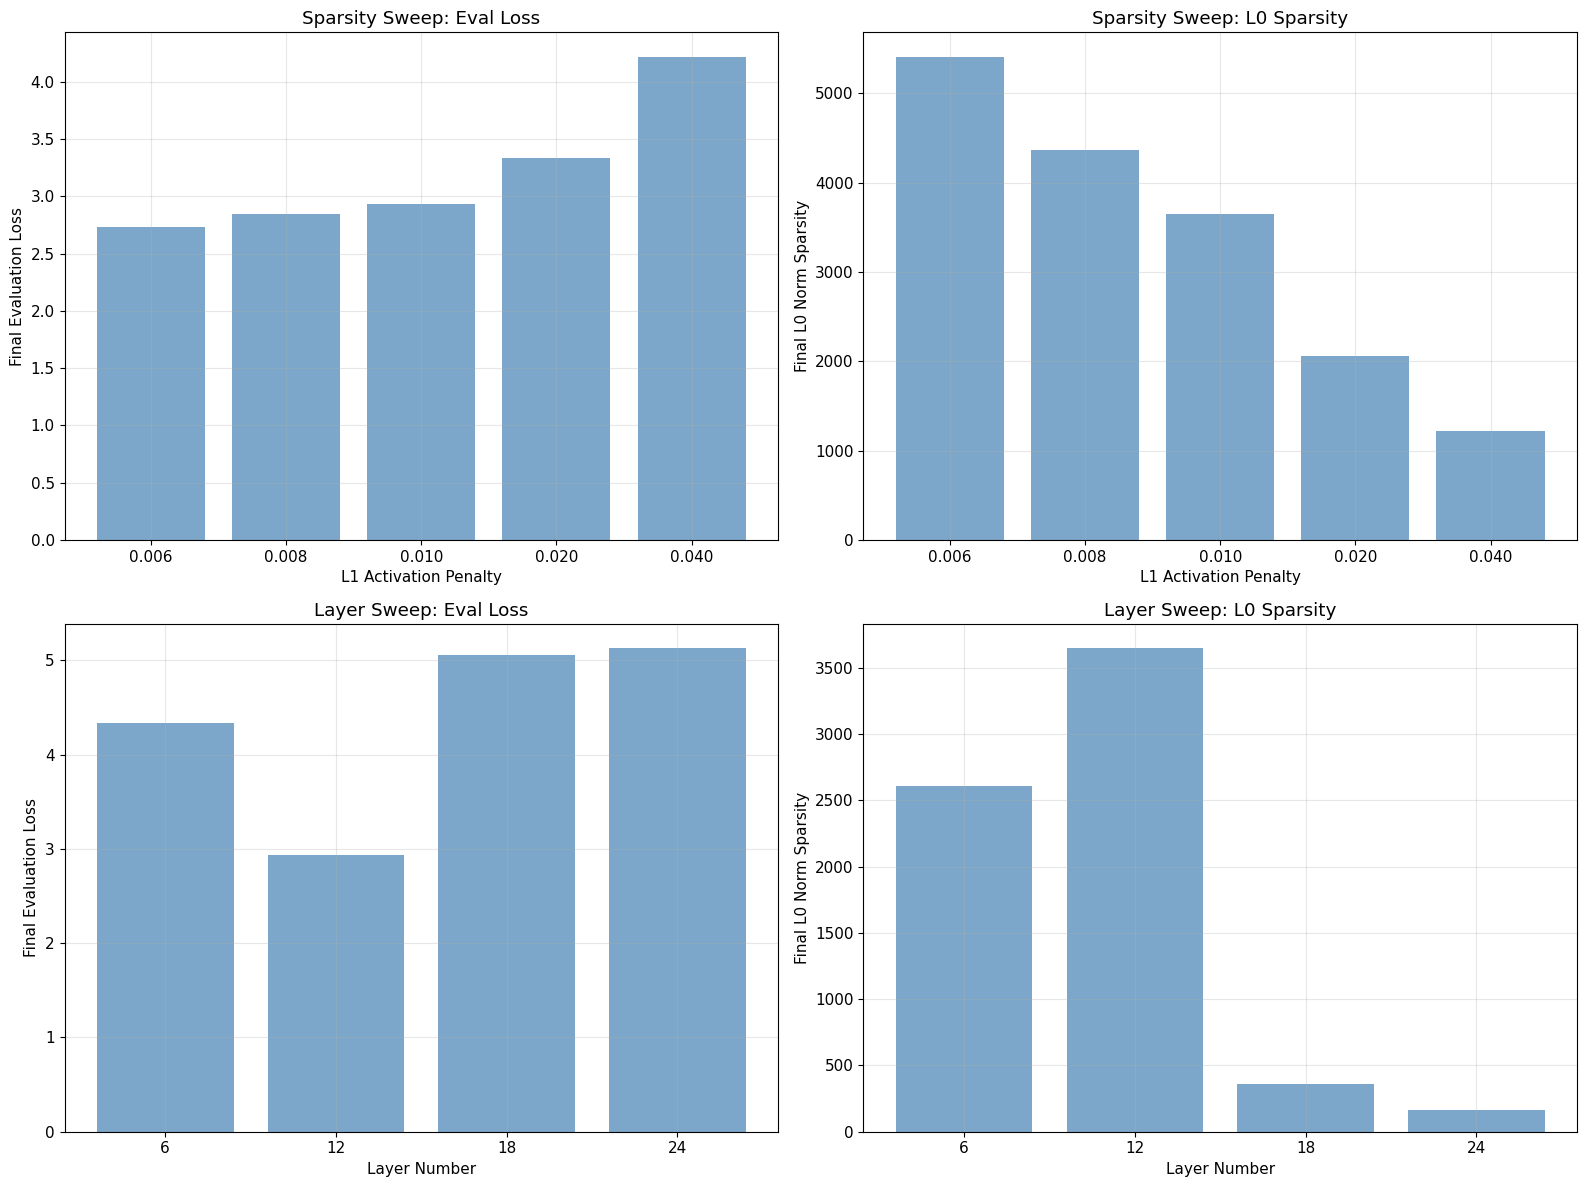

Combined plot saved to outputs/combined_results_plot.png


In [15]:
# Create a combined plot showing all 4 analyses in subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Combined sparsity data - eval loss (single color, discrete x-axis)
sparsity_eval_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'eval_loss'])
if len(sparsity_eval_data) > 0:
    grouped_data = sparsity_eval_data.groupby('l1_act_coeff')['eval_loss'].mean().sort_index()
    x_positions = range(len(grouped_data))
    ax1.bar(x_positions, grouped_data.values, alpha=0.7, width=0.8, color='steelblue')
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([f'{x:.3f}' for x in grouped_data.index])
    ax1.set_xlabel('L1 Activation Penalty')
    ax1.set_ylabel('Final Evaluation Loss')
    ax1.set_title('Sparsity Sweep: Eval Loss')
    ax1.grid(True, alpha=0.3)

# Plot 2: Combined sparsity data - l0 sparsity (single color, discrete x-axis)
sparsity_l0_data = combined_sparsity_data.dropna(subset=['l1_act_coeff', 'train_l0_norm_sparsity'])
if len(sparsity_l0_data) > 0:
    grouped_data = sparsity_l0_data.groupby('l1_act_coeff')['train_l0_norm_sparsity'].mean().sort_index()
    x_positions = range(len(grouped_data))
    ax2.bar(x_positions, grouped_data.values, alpha=0.7, width=0.8, color='steelblue')
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([f'{x:.3f}' for x in grouped_data.index])
    ax2.set_xlabel('L1 Activation Penalty')
    ax2.set_ylabel('Final L0 Norm Sparsity')
    ax2.set_title('Sparsity Sweep: L0 Sparsity')
    ax2.grid(True, alpha=0.3)

# Plot 3: Layer sweep - eval loss
layer_eval_data = layer_data.dropna(subset=['layer', 'eval_loss'])
if len(layer_eval_data) > 0:
    grouped_data = layer_eval_data.groupby('layer')['eval_loss'].mean().sort_index()
    ax3.bar(range(len(grouped_data)), grouped_data.values, alpha=0.7, color='steelblue')
    ax3.set_xticks(range(len(grouped_data)))
    ax3.set_xticklabels([str(int(x)) for x in grouped_data.index])
    ax3.set_xlabel('Layer Number')
    ax3.set_ylabel('Final Evaluation Loss')
    ax3.set_title('Layer Sweep: Eval Loss')
    ax3.grid(True, alpha=0.3)

# Plot 4: Layer sweep - l0 sparsity
layer_l0_data = layer_data.dropna(subset=['layer', 'train_l0_norm_sparsity'])
if len(layer_l0_data) > 0:
    grouped_data = layer_l0_data.groupby('layer')['train_l0_norm_sparsity'].mean().sort_index()
    ax4.bar(range(len(grouped_data)), grouped_data.values, alpha=0.7, color='steelblue')
    ax4.set_xticks(range(len(grouped_data)))
    ax4.set_xticklabels([str(int(x)) for x in grouped_data.index])
    ax4.set_xlabel('Layer Number')
    ax4.set_ylabel('Final L0 Norm Sparsity')
    ax4.set_title('Layer Sweep: L0 Sparsity')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/combined_results_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Combined plot saved to {output_dir}/combined_results_plot.png")